In [1]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlexC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = "cuda"
!nvidia-smi

Sat Jan 28 16:29:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   59C    P2    59W / 250W |    822MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
urls = [f"https://github.com/cluffa/crossfit-workouts/raw/main/data/{year}.csv" for year in range(2001, 2022)]
dfs = [pd.read_csv(url) for url in urls]

In [5]:
df = pd.concat(dfs, ignore_index = True)
df

,id,text,url
0,10228,Swim leisurely for thirty minutes. Make this r...,https://www.crossfit.com/workout/2001/02/28
1,10227,We are due for a little circuit work. Circuit ...,https://www.crossfit.com/workout/2001/02/27
2,10226,"If nobody minds, we'll give the legs a little ...",https://www.crossfit.com/workout/2001/02/26
3,10225,1) Bike 20 minutes at a warm-up pace.<|newline...,https://www.crossfit.com/workout/2001/02/25
4,10224,Rope Climb X 3<|newline|>Box Jump 2mins (50 ju...,https://www.crossfit.com/workout/2001/02/24
...,...,...,...
7548,211205,Complete as many rounds as possible in 20 minu...,https://www.crossfit.com/workout/2021/12/05
7549,211204,Nasty Girls V2<|newline|>3 rounds for time of:...,https://www.crossfit.com/workout/2021/12/04
7550,211203,Rest Day,https://www.crossfit.com/workout/2021/12/03
7551,211202,Muscle snatch 1-1-1-1-1 reps<|newline|>Power s...,https://www.crossfit.com/workout/2021/12/02


In [6]:
df.dropna(inplace=True) #remove NA values
bios = df.text.copy() #just use the main bio text in this example
bios

0       Swim leisurely for thirty minutes. Make this r...
1       We are due for a little circuit work. Circuit ...
2       If nobody minds, we'll give the legs a little ...
3       1) Bike 20 minutes at a warm-up pace.<|newline...
4       Rope Climb X 3<|newline|>Box Jump 2mins (50 ju...
                              ...                        
7548    Complete as many rounds as possible in 20 minu...
7549    Nasty Girls V2<|newline|>3 rounds for time of:...
7550                                             Rest Day
7551    Muscle snatch 1-1-1-1-1 reps<|newline|>Power s...
7552    3 rounds for time of:<|newline|>500-m row<|new...
Name: text, Length: 7542, dtype: object

<AxesSubplot: ylabel='Count'>

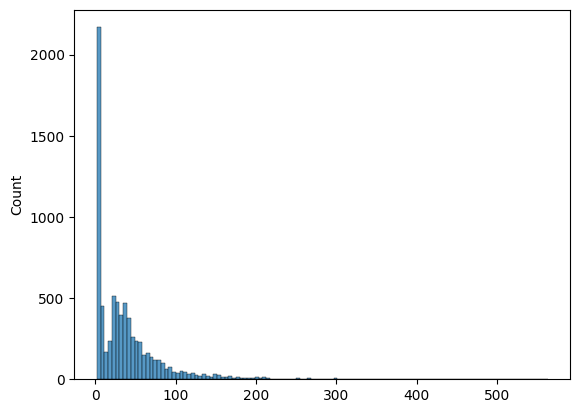

In [7]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.histplot(doc_lengths)

In [8]:
len(doc_lengths[doc_lengths > 256])/len(doc_lengths)

0.005833996287456908

In [9]:
np.average(doc_lengths)

38.55833996287457

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
batch_size = 8

In [22]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [23]:
dataset = GPT2Dataset(bios, tokenizer, max_length=256)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,787 training samples
  755 validation samples


In [24]:
train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset, # The validation samples.
    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

In [25]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device(device)
model.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [26]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 500

In [27]:
optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = epsilon
)

In [28]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = warmup_steps, 
    num_training_steps = total_steps
)

In [29]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [30]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            # model.eval()

            # sample_outputs = model.generate(
            #                         bos_token_id=random.randint(1,30000),
            #                         do_sample=True,   
            #                         top_k=50, 
            #                         max_length = 200,
            #                         top_p=0.95, 
            #                         num_return_sequences=1
            #                     )
            # for i, sample_output in enumerate(sample_outputs):
            #       print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            # model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   500  of    849. Loss: 0.272686243057251.   Elapsed: 0:02:54.

  Average training loss: 0.61
  Training epoch took: 0:04:55

Running Validation...
  Validation Loss: 0.28
  Validation took: 0:00:10

======== Epoch 2 / 5 ========
Training...
  Batch   500  of    849. Loss: 0.4204094707965851.   Elapsed: 0:02:57.

  Average training loss: 0.26
  Training epoch took: 0:05:03

Running Validation...
  Validation Loss: 0.25
  Validation took: 0:00:10

======== Epoch 3 / 5 ========
Training...
  Batch   500  of    849. Loss: 0.19313260912895203.   Elapsed: 0:02:57.

  Average training loss: 0.21
  Training epoch took: 0:04:59

Running Validation...
  Validation Loss: 0.25
  Validation took: 0:00:10

======== Epoch 4 / 5 ========
Training...
  Batch   500  of    849. Loss: 0.27068376541137695.   Elapsed: 0:02:57.

  Average training loss: 0.17
  Training epoch took: 0:05:00

Running Validation...
  Validation Loss: 0.25
  Validation took: 0:0

In [31]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.609091,0.277289,0:04:55,0:00:10
2,0.257787,0.253026,0:05:03,0:00:10
3,0.205607,0.251485,0:04:59,0:00:10
4,0.166654,0.254048,0:05:00,0:00:10
5,0.136430,0.265778,0:04:47,0:00:09


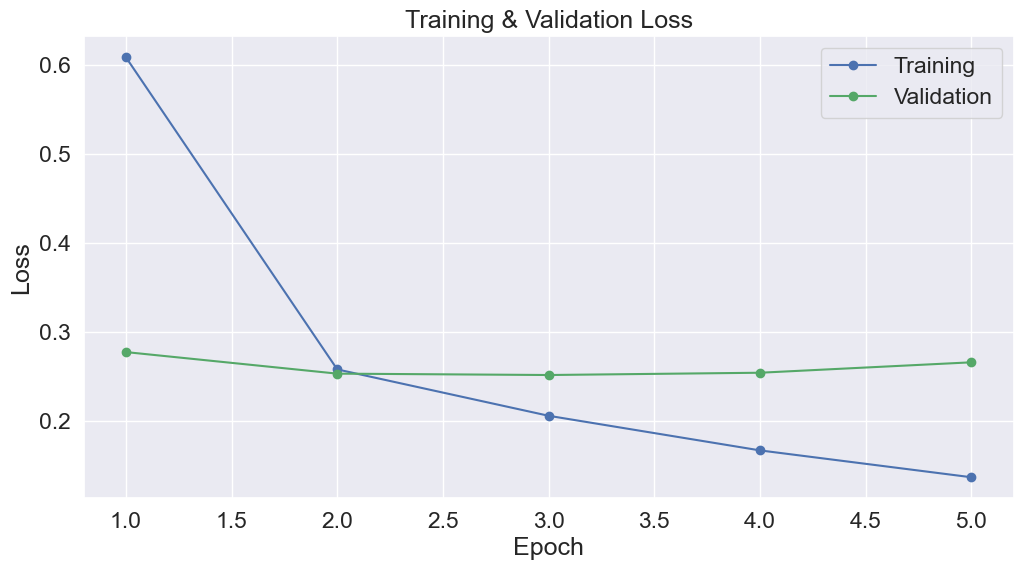

In [32]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4])

plt.show()

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [33]:
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [40]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
    generated, 
    #bos_token_id=random.randint(1,30000),
    do_sample=True,   
    top_k=50, 
    max_length = 300,
    top_p=0.95, 
    num_return_sequences=7
)

with open("output.txt", "w", encoding="utf-8") as f:
    for i, sample_output in enumerate(sample_outputs):
        outstr = "---- {} ----\n{}\n".format(i+1, tokenizer.decode(sample_output, skip_special_tokens=True))
        outstr = outstr.replace("<|newline|>", "\n")
        f.writelines(outstr)
        print(outstr)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
---- 1 ----
Hang squat clean 5-5-5-5-5 reps


---- 2 ----
For time:
25 Muscle ups
15 Power cleans
15 GHD sit-ups
5 Power cleans
15 Handstand push-ups
5 Muscle ups
10 Muscle ups
9 Muscle ups
8 Muscle ups
7 Muscle ups
6 Muscle ups
5 Muscle ups
4 Muscle ups
3 Muscle ups
2 Muscle ups
1 Muscle ups
Use a 2-pood kettlebell.


---- 3 ----
Run 5K
"We are a small group of thoughtful, committed citizens in our own right, but the world needs change. It is our nature to resist the growing influence of commercial life, but we can do without it."
- Sir Winston Churchill


---- 4 ----
Rest Day

---- 5 ----
For time:
Row 750 meters
50 GHD sit-ups
Row 750 meters
40 GHD sit-ups
Row 750 meters
20 GHD sit-ups


---- 6 ----
Complete as many rounds as possible in 20 minutes of:
95-pound Push jerk, 15 reps
3⁄4 body weight Push jerk, 15 reps
1⁄2 body weight Push jerk, 15 reps
2⁄4 body weight Push jerk, 15 reps
3⁄4 body weight Push jerk, 15 reps
"Concentration is the ability t

In [41]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro